<a href="https://colab.research.google.com/github/music-ai-644/AI_Study_2022/blob/main/Chapter9_%EC%88%98%EC%97%85%20%EC%9E%90%EB%A3%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 영화 리뷰 데이터셋
## 텍스트 분류하기 

### 1. 데이터 불러오기 

In [2]:
import numpy as np 
from tensorflow.keras.datasets import imdb

(x_train_all, y_train_all), (x_test, y_test) = imdb.load_data(skip_top=20, num_words=200)
# skip_top 제일 많이 나오는 단어 20개는 삭제 (a, the 같은 관사일 수 있음)
# num_words 단어의 개수를 설정 

- 데이터셋 확인 

![figure3](https://github.com/music-ai-644/AI_Study_2022/blob/main/figure/Chapter9_3.PNG?raw=true)

- 인터넷 영화 평점 사이트의 댓글 데이터 셋 
- 리뷰 하나가 들어왔을 때 문장(문자열)을 보고 긍정(1) 인지, 부정(0)인지 예측하는 학습에 사용
- 이러한 task를 감성 분석(sentimental analysis)이라고 함

In [3]:
print(x_train_all.shape, y_train_all.shape)

(25000,) (25000,)


![figure4](https://github.com/music-ai-644/AI_Study_2022/blob/main/figure/Chapter9_4.PNG?raw=true)

In [4]:
print("첫 번째 sequence의 길이 : ", len(x_train_all[0]))
print("두 번째 sequence의 길이 : ", len(x_train_all[1]))

첫 번째 sequence의 길이 :  218
두 번째 sequence의 길이 :  189


In [5]:
print("첫 번째 sequence의 타겟값 : ", y_train_all[0])
print("두 번째 sequence의 타겟값 : ", y_train_all[1])

첫 번째 sequence의 타겟값 :  1
두 번째 sequence의 타겟값 :  0


In [6]:
from sklearn.model_selection import train_test_split 
x_train, x_valid, y_train, y_valid = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)

훈련 데이터 셋 길이의 평균   :  238.4934
훈련 데이터 셋 길이의 중간값 :  178.0


Text(0, 0.5, 'frequency')

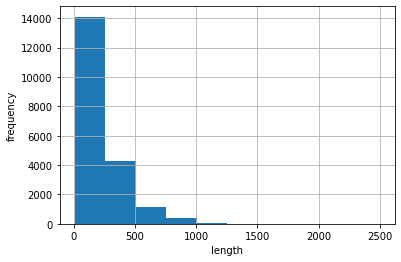

In [7]:
import matplotlib.pyplot as plt 
lengths = np.array([len(x) for x in x_train])  # train set의 sequence의 길이들을 모음 
print("훈련 데이터 셋 길이의 평균   : ", np.mean(lengths))
print("훈련 데이터 셋 길이의 중간값 : ", np.median(lengths))

plt.hist(lengths)
plt.grid()
plt.xlabel("length")
plt.ylabel("frequency")

### 2. 샘플 길이 맞추고 원-핫 인코딩하기

![figure1](https://github.com/music-ai-644/AI_Study_2022/blob/main/figure/Chapter9_1.PNG?raw=true)
- 순환 신경망의 경우, sequence의 길이가 짧은 경우, 뒤에 하는 것이 아니라 앞에 함
- 텍스트 분류를 위해서 신경망의 가장 마지막 output을 사용하게 되는데, 이 때 뒤에 패딩한 값(zero 혹은 기타)이 영향을 주게 되어 실제 데이터와 무관한 값이 나올 수 있음

![figure2](https://github.com/music-ai-644/AI_Study_2022/blob/main/figure/Chapter9_2.PNG?raw=true)

In [8]:
from tensorflow.keras.preprocessing import sequence 

maxlen = 200  # 배치 내의 sequence의 길이를 최대 100으로 함 
x_train_seq = sequence.pad_sequences(x_train, maxlen=maxlen)
x_valid_seq = sequence.pad_sequences(x_valid, maxlen=maxlen)
x_test_seq = sequence.pad_sequences(x_test, maxlen=maxlen)

![figure5](https://github.com/music-ai-644/AI_Study_2022/blob/main/figure/Chapter9_5.PNG?raw=true)

In [9]:
print("훈련 데이터 셋의 형태 : ", np.shape(x_train_seq))

훈련 데이터 셋의 형태 :  (20000, 200)


In [10]:
from tensorflow.keras.utils import to_categorical 

# x_train_onehot = to_categorical(x_train_seq)
# x_valid_onehot = to_categorical(x_valid_seq)

In [12]:
print("훈련 데이터 셋의 타겟 : ", np.shape(x_train_seq))  # (전체 샘플 개수, sequence 길이, 단어의 개수)
print("평가 데이터 셋의 타겟 : ", np.shape(x_valid_seq))  # (전체 샘플 개수, sequence 길이, 단어의 개수)

훈련 데이터 셋의 타겟 :  (20000, 200)
평가 데이터 셋의 타겟 :  (5000, 200)


In [13]:
import torch
x_train_torch = torch.FloatTensor(x_train_seq)
y_train_torch = torch.FloatTensor(y_train)
x_valid_torch = torch.FloatTensor(x_valid_seq)
y_valid_torch = torch.FloatTensor(y_valid) 
x_test_torch = torch.FloatTensor(x_test_seq)
y_test_torch = torch.FloatTensor(y_test) 

In [14]:
import torch.nn as nn 
from torch.utils.data import Dataset, DataLoader 

In [15]:
class IMDBDataset(Dataset):
  def __init__(self, x, y):
    self.x_data = x 
    self.y_data = y 

  def __getitem__(self, index):
    x = self.x_data[index]
    y = self.y_data[index]
    return x, y

  def collate_fn(self, batch):
    x, y = zip(*batch)
    return x, y 

  def __len__(self):
    return len(self.x_data)


In [16]:
dataset = IMDBDataset(x_train_torch, y_train_torch)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, drop_last=True)
valid_dataset = IMDBDataset(x_valid_torch, y_valid_torch)
valid_dataloader = DataLoader(valid_dataset, batch_size=20, shuffle=False, drop_last=False)

In [46]:
class MyModel(nn.Module):
  def __init__(self):
    super(MyModel, self).__init__()
    self.n_layer = 1
    self.n_hidden = 100
    self.embedding = nn.Embedding(200, self.n_hidden)
    self.rnn = nn.RNN(self.n_hidden, self.n_hidden)
    self.net = nn.Sequential(nn.Linear(self.n_hidden, 1), nn.Sigmoid())
  
  def forward(self, x, hidden):
    x = self.embedding(x)
    output, hidden = self.rnn(x, hidden)
    predicts = self.net(output)
    return predicts[-1, :, :], hidden

  def predict(self, x):
    predicts = []
    len_x = x.size(1)
    for i in range(len_x):
      pred = model(x[:, i].unsqueeze(1))
      predicts.append(pred.data.numpy()[0])
    return np.array(predicts) > 0.5

  def init_hidden(self, batch_size):
    h0 = torch.zeros(self.n_layer, batch_size, self.n_hidden)
    return h0
    

In [47]:
from tqdm import tqdm 
import random 

random_seed = 123
np.random.seed(random_seed)
torch.manual_seed(random_seed)
random.seed(random_seed)

model = MyModel() 
model.train()

optim = torch.optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.BCELoss()

global_step = 0 
for epoch in range(10):
  t = tqdm(dataloader, ncols=100)
  hidden = model.init_hidden(8)
  for i, batch in enumerate(t):
    x_batch = batch[0]
    y_batch = batch[1]
    x_batch = x_batch.transpose(0, 1)
    predicts, hidden = model(x_batch.long(), hidden)
    loss = criterion(predicts[:,0], y_batch)
    loss.backward()
    optim.step()

    global_step += 1
    t.set_description("epoch: {} | global_step: {:8d} | loss: {:.4f}".format(epoch + 1, global_step, loss))
  
  with torch.no_grad():
    model.eval()
    predicts = model.predict(x_valid_torch.transpose(0, 1).long())
    result = np.mean(predicts == y_test)
    print("정확도 : {:%}".format(result))
    model.train()

epoch: 1 | global_step:        1 | loss: 0.6373:   0%|             | 1/2500 [00:00<11:14,  3.70it/s]/usr/local/lib/python3.7/dist-packages/torch/autograd/__init__.py:175: UserWarning: Error detected in TanhBackward0. Traceback of forward call that caused the error:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/lib/python3.7/dist-packages/ipykernel/kernelapp.py", line 499, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.7/dist-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.7/asyncio/base_events.py", l

RuntimeError: ignored

In [ ]:
result = np.mean(predicts(x_test_torch) == y_test)
print("epoch: {} | global_step: {} | valid acc: {:%}".format(epoch + 1, global_step, acc))